In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy
import imodels
import eval_feat_select
from collections import defaultdict
from typing import List
import dvu
import imodelsx
import imodelsx.viz
import imodelsx.llm
import feat_select
import viz_feat_select
import guidance
import openai
openai.api_key_path = '/home/chansingh/.OPENAI_KEY'
dvu.set_style()
outcome = 'tbi_young'
dset_dict = feat_select.DSET_DICTS[outcome]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Gather important features

(42428,)
Unique features: 63


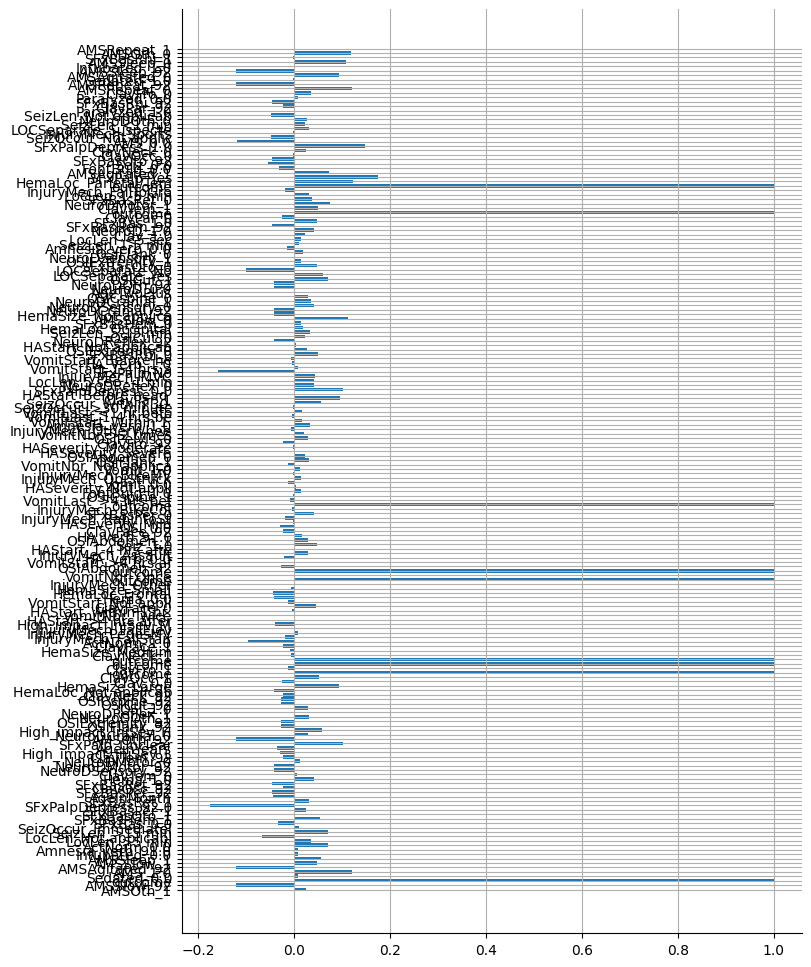

In [6]:
X, y, feats_raw, feats_abbrev_unique = dset_dict['get_data']()
df = pd.DataFrame(X, columns=feats_raw)
df["outcome"] = y
# X, y, feats_raw, feats_abbrev_unique = feat_select.get_tbi_data()
print(f"Unique features: {len(feats_abbrev_unique)}")


plt.figure(figsize=(8, 12))
n = df.shape[1] - 1
args = np.argsort(df.corr()["outcome"][:-1])
# plt.barh(y=np.arange(n), width=df.corr()["outcome"][:-1])
plt.barh(y=np.arange(n), width=df.corr()["outcome"][args])
# plt.yticks(np.arange(n), pd.Series(df.columns[:-1]).apply(lambda x: x[:20]))
plt.yticks(np.arange(n), pd.Series(df.columns[args]).apply(lambda x: x[:20]))
plt.grid()
plt.show()

In [108]:
feats_clean = feat_select.ABBREV_TO_CLEAN_IAI.values()
# list(feats_clean)
RISK_CONTRIBUTION = {
    'Abdominal distention': 1,
    'Abdominal wall trauma': 1,
    'Abdominal pain': 1,
    'Full GCS score': 0,
    'Hypotension': 1,
    'Severe abdominal tenderness': 1,
    'Costal margin tenderness': 1,
    # 'Decreased breath sounds': 1,
    'Normal breath sounds': 0,
    'Distracting pain': 1,
    'Seatbelt sign': 1,
    'Thoracic tenderness': 1,
    'Thoracic trauma': 1,
    'Vomiting': 1,
}
feat_names = list(RISK_CONTRIBUTION.keys())

### Check predictions

In [109]:
guidance.llm = guidance.llms.OpenAI("gpt-4-0314")
increase_or_decrease = guidance(
'''{{#system~}}
You are a helpful assistant.
{{~/system}}
{{#user~}}
Does the presence of {{feat_name}} tend to increase or decrease the risk of intra-abdominal injury?  Please answer with a single word, either "Increase" or "Decrease".
{{~/user}}
{{#assistant~}}
{{gen 'answer' stop="\\n-"}}
{{~/assistant}}''')

In [110]:
# guidance.llm = guidance.llms.OpenAI("text-ada-001")
# increase_or_decrease = guidance(
# '''Does the presence of {{feat_name}} tend to increase or decrease the risk of intra-abdominal injury?  Please answer with a single word, either "Increase" or "Decrease".
# Answer: {{#select "answer" logprobs='logprobs'}}Increase{{or}}Decrease{{/select}}''')

In [111]:
preds = []
for feat_name in tqdm(feat_names):
    preds.append(increase_or_decrease(feat_name=feat_name)['answer'])

Stop program system You are a helpful assistant. user Does the presence of Vomiting tend to increase or decrease the risk of intra-abdominal injury? Please answer with a single word, either "Increase" or "Decrease". assistant Increase

100%|██████████| 13/13 [00:00<00:00, 19.00it/s]


In [118]:
d = pd.DataFrame.from_dict({
    'feat_names': feat_names,
    'preds': preds,
    'gt': list(RISK_CONTRIBUTION.values())
})
acc = (d['preds'].str.lower().str.startswith('inc').astype(int) == d['gt']).mean()
print('acc', acc)
d

acc 1.0


,feat_names,preds,gt
0,Abdominal distention,Increase,1
1,Abdominal wall trauma,Increase,1
2,Abdominal pain,Increase,1
3,Full GCS score,Decrease,0
4,Hypotension,Increase,1
5,Severe abdominal tenderness,Increase,1
6,Costal margin tenderness,Increase,1
7,Normal breath sounds,Decrease,0
8,Distracting pain,Increase,1
9,Seatbelt sign,Increase,1
